In [ ]:
import pandas as pd
import numpy as np
import os
import sys

pred = pd.read_csv("predictions_2025-05-15_14-06-46.csv")
true = pd.read_csv("../data/artemis-v2/dataset/combined/train/artemis_per_image_weighted.csv")

ARTEMIS_EMOTIONS = sorted(['amusement', 'awe', 'contentment', 'excitement',
                    'anger', 'disgust',  'fear', 'sadness', 'something else'])

EMOTION_TO_IDX = {e: i for i, e in enumerate(ARTEMIS_EMOTIONS)}


IDX_TO_EMOTION = {EMOTION_TO_IDX[e]: e for e in EMOTION_TO_IDX}

In [2]:
pred.shape, true[true['split'] == 'test'].shape

((7190, 10), (7190, 4))

In [ ]:
test_df = true[true['split'] == 'test'].reset_index(drop=True)


# Get max probability per row
pred['max_prob'] = pred.drop('image_file', axis=1).max(axis=1)

# Get emotion name of the max probability per row
pred['max_emotion'] = pred.drop('image_file', axis=1).idxmax(axis=1)

<Axes: title={'center': 'Predictions per emotion'}, xlabel='max_emotion'>

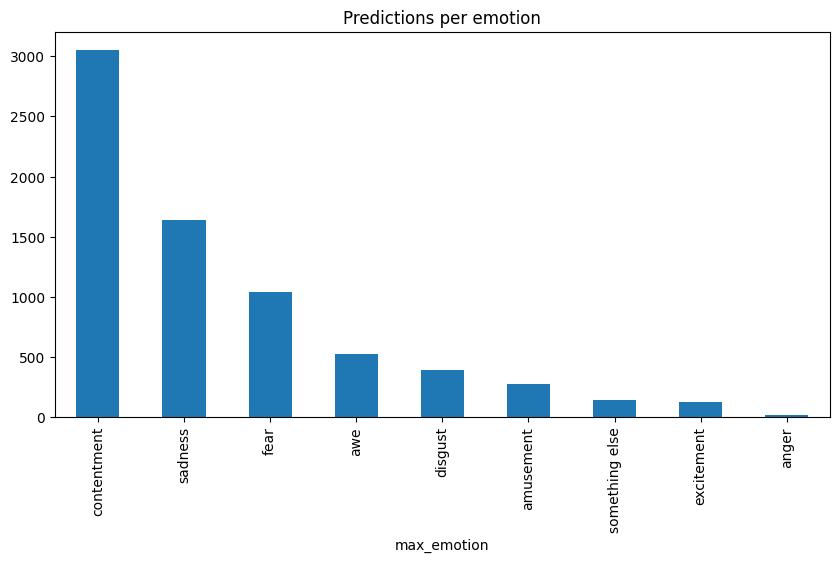

In [4]:
pred.max_emotion.value_counts().plot(kind='bar', figsize=(10, 5), title='Predictions per emotion')

In [ ]:
# check how many times the dominant (most frequent) emotion appears in each split
def get_dominant_emotion(row):
    if row.max() < 0.5:
        return None
    return idx_to_emotion[row.argmax().item()]
test_df['dominant_emotion'] = test_df['multi_hot_label'].apply(get_dominant_emotion)
test_df['dominant_emotion'].value_counts().sum()
# Fix the KeyError by ensuring the majority_class is correctly calculated
majority_class = test_df['dominant_emotion'].value_counts().idxmax()
majority_class_count = test_df['dominant_emotion'].value_counts()[majority_class]
print(f"Majority class: {majority_class} appears {majority_class_count / len(test_df) * 100:.2f}% of the time")



image_file           object
split                object
multi_hot_label      object
total_annotations     int64
dtype: object

AttributeError: 'str' object has no attribute 'max'

## Baseline ResNet accuracy

In [ ]:
pred = pd.read_csv("predictions/predictions_2025-05-15_14-06-46.csv")

# Get max probability per row
pred['max_prob'] = pred.drop('image_file', axis=1).max(axis=1)

# Get emotion name of the max probability per row
pred['max_emotion'] = pred.drop('image_file', axis=1).idxmax(axis=1)

In [ ]:
# match pred and test_df on image_file and compare the dominant_emotion with max_emotion to calculate accuracy

merged_df = pd.merge(test_df, pred[['image_file', 'max_emotion']], on='image_file', how='left')

# Calculate accuracy
accuracy = (merged_df['dominant_emotion'] == merged_df['max_emotion']).mean() * 100
print(f"Accuracy of the baseline model on the test subset: {accuracy:.2f}")

## Calculate Confidence Intervals and check statistical significance

In [ ]:
# Calculate confidence interval for accuracy
import scipy.stats as stats

n = len(merged_df)  # Sample size

# Standard error of the proportion
std_err = np.sqrt((accuracy/100 * (1 - accuracy/100)) / n)

# Calculate 95% confidence interval
# Using the normal approximation since we have a large sample
z_critical = stats.norm.ppf(0.975)  # 97.5th percentile for 95% CI
margin_of_error = z_critical * std_err * 100
lower_ci = accuracy - margin_of_error
upper_ci = accuracy + margin_of_error

print(f"Accuracy of the baseline model on the test subset: {accuracy:.2f}%")
print(f"95% Confidence Interval: [{lower_ci:.2f}%, {upper_ci:.2f}%]")

In [ ]:
# Calculate accuracy for majority class classifier
# Assign majority class to all predictions
majority_class = test_df['dominant_emotion'].value_counts().idxmax()
majority_class_count = test_df['dominant_emotion'].value_counts()[majority_class]
majority_accuracy = (test_df['dominant_emotion'] == majority_class).mean() * 100

# Calculate confidence interval for majority class accuracy
import scipy.stats as stats

n = len(test_df)  # Sample size
std_err_majority = np.sqrt((majority_accuracy/100 * (1 - majority_accuracy/100)) / n)
z_critical = stats.norm.ppf(0.975)  # 97.5th percentile for 95% CI
margin_of_error_majority = z_critical * std_err_majority * 100
lower_ci_majority = majority_accuracy - margin_of_error_majority
upper_ci_majority = majority_accuracy + margin_of_error_majority

print(f"Majority class: {majority_class} appears {majority_class_count / len(test_df) * 100:.2f}% of the time")
print(f"Majority class accuracy: {majority_accuracy:.2f}%")
print(f"95% Confidence Interval: [{lower_ci_majority:.2f}%, {upper_ci_majority:.2f}%]")

# Compare with model accuracy
print("\nComparison:")
print(f"Model accuracy: {accuracy:.2f}% (95% CI: [{lower_ci:.2f}%, {upper_ci:.2f}%])")
print(f"Majority class accuracy: {majority_accuracy:.2f}% (95% CI: [{lower_ci_majority:.2f}%, {upper_ci_majority:.2f}%])")

# Calculate if the difference is statistically significant
z_diff = (accuracy - majority_accuracy) / np.sqrt((std_err**2) + (std_err_majority**2)) * 100
p_value = 2 * (1 - stats.norm.cdf(abs(z_diff)))  # Two-tailed test

print(f"\nStatistical significance of difference:")
print(f"Z-score: {z_diff:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"The difference is {'statistically significant (p<0.05)' if p_value < 0.05 else 'not statistically significant (p≥0.05)'}")